In [1]:
import os
import sys
sys.path.append('/nfs/z1/userhome/ChenXiaYu/workingdir/code/MagicBox')
import time
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats import sem, pearsonr
from scipy.spatial.distance import pdist
from sklearn.preprocessing import minmax_scale
from matplotlib import pyplot as plt
from magicbox.io.io import CiftiReader, GiftiReader
from magicbox.algo.tool import smooth_1d, round_decimal
from magicbox.vis.plot import plot_bar, plot_polyfit
from magicbox.graph.triangular_mesh import label_edge_detection,\
    get_n_ring_neighbor
from cxy_visual_dev.lib.predefine import proj_dir, Atlas,\
    get_rois, mmp_map_file, LR_count_32k, mmp_name2label,\
    meas2color, MedialWall, s1200_midthickness_L, s1200_midthickness_R,\
    Hemi2stru
from cxy_visual_dev.lib.algo import AgeSlideWindow

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/tmp')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# ROI_neighbor

## PC1和PC2的 脑区间差异和脑区内变异的比值 的小提琴图

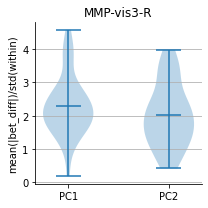

In [2]:
figsize = (3, 3)
vis_name = 'MMP-vis3-R'
pc_names = ['PC1', 'PC2']
fpath = pjoin(anal_dir, f'ROI_neighbor/neighbor-contrast_{vis_name}.pkl')
out_file = pjoin(work_dir, f'neighbor-contrast1_{vis_name}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))

n_pc = len(pc_names)
x = np.arange(1, n_pc+1)
ys = []
for pc_name in pc_names:
    arr = np.abs(data[pc_name])
    n_roi = arr.shape[0]
    pc_y = np.zeros(n_roi)
    for roi_idx in range(n_roi):
        roi_row = arr[roi_idx, :]
        pc_std = roi_row[roi_idx]
        roi_row[roi_idx] = np.nan
        pc_mean = np.nanmean(roi_row)
        pc_y[roi_idx] = pc_mean / pc_std
    ys.append(pc_y)

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.violinplot(ys, x, showmeans=True)
ax.yaxis.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(pc_names)
ax.set_ylabel('mean(|bet_diff|)/std(within)')
ax.set_title(vis_name)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## PC1和PC2在两两相邻脑区之间的差异 小提琴图

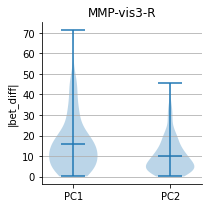

In [3]:
figsize = (3, 3)
vis_name = 'MMP-vis3-R'
pc_names = ['PC1', 'PC2']
fpath = pjoin(anal_dir, f'ROI_neighbor/neighbor-contrast_{vis_name}.pkl')
out_file = pjoin(work_dir, f'neighbor-contrast2_{vis_name}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
n_roi = len(data['roi'])
idx_mat = np.tri(n_roi, k=-1, dtype=bool).T

n_pc = len(pc_names)
x = np.arange(1, n_pc+1)
ys = []
for pc_name in pc_names:
    y = data[pc_name][idx_mat]
    nan_idx_vec = np.isnan(y)
    ys.append(np.abs(y[~nan_idx_vec]))

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.violinplot(ys, x, showmeans=True)
ax.yaxis.grid(True)
ax.set_xticks(x)
ax.set_xticklabels(pc_names)
ax.set_ylabel('|bet_diff|')
ax.set_title(vis_name)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用一维数组展示用数据点之间的空间距离和数值差异的相关代表数值空间平滑度的原理

## 将某1d数组随机打乱顺序

polynomial:
  
0.004877 x - 0.1037

score: PearsonRResult(statistic=0.9429050644241902, pvalue=4.3380829485767726e-05)
pearsonr(x, y, alternative='greater'):
 PearsonRResult(statistic=0.9429050644241901, pvalue=2.1690414742884032e-05)


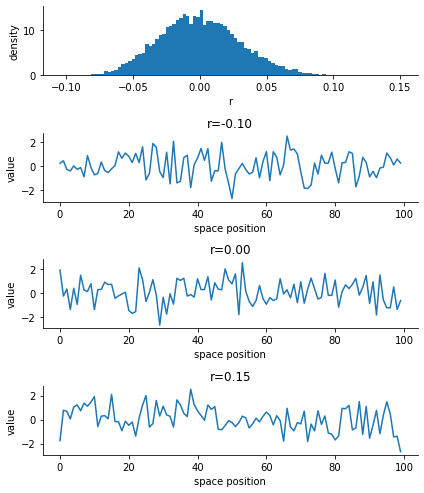

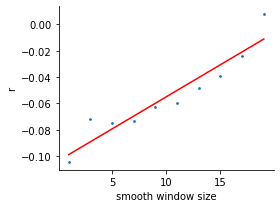

In [2]:
# 代码已备份，暂时勿动
n_point = 100
n_test = 10000
figsize1 = (6, 7)
figsize2 = (4, 3)
out_file1 = pjoin(work_dir, 'smoothness_demo1.jpg')
out_file2 = pjoin(work_dir, 'smoothness_demo2.jpg')
# out_file1 = 'show'
# out_file2 = 'show'

x = np.arange(n_point)
vec = np.random.randn(100)
vec_min = None
vec_min_score = np.inf
vec_mid = None
vec_mid_score = np.inf
vec_max = None
vec_max_score = -np.inf

space_ds = pdist(np.expand_dims(x, 1), metric='euclidean')
rs = np.zeros(n_test)
for i in range(n_test):
    np.random.shuffle(vec)
    value_ds = pdist(np.expand_dims(vec, 1), metric='euclidean')
    r = pearsonr(space_ds, value_ds)[0]
    if r < vec_min_score:
        vec_min = vec.copy()
        vec_min_score = r
    if np.abs(r) < vec_mid_score:
        vec_mid = vec.copy()
        vec_mid_score = np.abs(r)
    if r > vec_max_score:
        vec_max = vec.copy()
        vec_max_score = r
    rs[i] = r

fig1, axes1 = plt.subplots(4, 1, figsize=figsize1)
axes1[0].hist(rs, 100, density=True)
axes1[0].set_xlabel('r')
axes1[0].set_ylabel('density')
axes1[0].spines['top'].set_visible(False)
axes1[0].spines['right'].set_visible(False)

axes1[1].plot(x, vec_min)
axes1[1].set_title('r={:.2f}'.format(vec_min_score))
axes1[1].set_xlabel('space position')
axes1[1].set_ylabel('value')
axes1[1].spines['top'].set_visible(False)
axes1[1].spines['right'].set_visible(False)

axes1[2].plot(x, vec_mid)
axes1[2].set_title('r={:.2f}'.format(vec_mid_score))
axes1[2].set_xlabel('space position')
axes1[2].set_ylabel('value')
axes1[2].spines['top'].set_visible(False)
axes1[2].spines['right'].set_visible(False)

axes1[3].plot(x, vec_max)
axes1[3].set_title('r={:.2f}'.format(vec_max_score))
axes1[3].set_xlabel('space position')
axes1[3].set_ylabel('value')
axes1[3].spines['top'].set_visible(False)
axes1[3].spines['right'].set_visible(False)

fig1.tight_layout()
if out_file1 == 'show':
    fig1.show()
else:
    fig1.savefig(out_file1)

win_lens = np.arange(3, 21, 2)
rs2 = np.zeros_like(win_lens, float)
for win_idx, win_len in enumerate(win_lens):
    vec_sm = smooth_1d(vec_min, 'flat', win_len)
    value_ds = pdist(np.expand_dims(vec_sm, 1), metric='euclidean')
    r = pearsonr(space_ds, value_ds)[0]
    rs2[win_idx] = r
win_lens = np.r_[(1,), win_lens]
rs2 = np.r_[(vec_min_score,), rs2]

fig2, ax2 = plt.subplots(1, 1, figsize=figsize2)
plot_polyfit(win_lens, rs2, 1, color='r', s=3, ax=ax2)
print("pearsonr(x, y, alternative='greater'):\n",
      pearsonr(win_lens, rs2, alternative='greater'))
ax2.set_xlabel('smooth window size')
ax2.set_ylabel('r')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig2.tight_layout()
if out_file2 == 'show':
    fig2.show()
else:
    fig2.savefig(out_file2)

## 随机多次生成1d数组

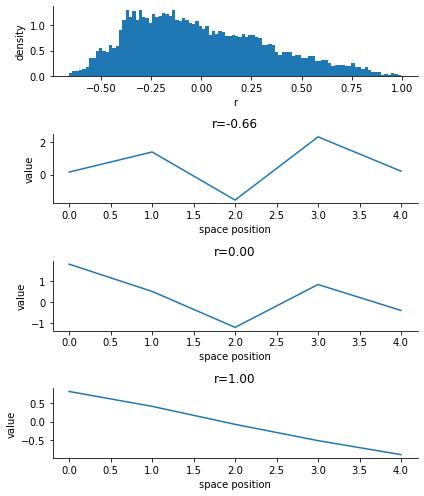

In [2]:
n_point = 5
n_test = 10000
figsize1 = (6, 7)
figsize2 = (4, 3)
out_file1 = pjoin(work_dir, 'smoothness_demo1.jpg')
# out_file2 = pjoin(work_dir, 'smoothness_demo2.jpg')
# out_file1 = 'show'
# out_file2 = 'show'

x = np.arange(n_point)
vec_min = None
vec_min_score = np.inf
vec_mid = None
vec_mid_score = np.inf
vec_max = None
vec_max_score = -np.inf

space_ds = pdist(np.expand_dims(x, 1), metric='euclidean')
rs = np.zeros(n_test)
for i in range(n_test):
    vec = np.random.randn(n_point)
    value_ds = pdist(np.expand_dims(vec, 1), metric='euclidean')
    r = pearsonr(space_ds, value_ds)[0]
    if r < vec_min_score:
        vec_min = vec
        vec_min_score = r
    if np.abs(r) < vec_mid_score:
        vec_mid = vec
        vec_mid_score = np.abs(r)
    if r > vec_max_score:
        vec_max = vec
        vec_max_score = r
    rs[i] = r

fig1, axes1 = plt.subplots(4, 1, figsize=figsize1)
axes1[0].hist(rs, 100, density=True)
axes1[0].set_xlabel('r')
axes1[0].set_ylabel('density')
axes1[0].spines['top'].set_visible(False)
axes1[0].spines['right'].set_visible(False)

axes1[1].plot(x, vec_min)
axes1[1].set_title('r={:.2f}'.format(vec_min_score))
axes1[1].set_xlabel('space position')
axes1[1].set_ylabel('value')
axes1[1].spines['top'].set_visible(False)
axes1[1].spines['right'].set_visible(False)

axes1[2].plot(x, vec_mid)
axes1[2].set_title('r={:.2f}'.format(vec_mid_score))
axes1[2].set_xlabel('space position')
axes1[2].set_ylabel('value')
axes1[2].spines['top'].set_visible(False)
axes1[2].spines['right'].set_visible(False)

axes1[3].plot(x, vec_max)
axes1[3].set_title('r={:.2f}'.format(vec_max_score))
axes1[3].set_xlabel('space position')
axes1[3].set_ylabel('value')
axes1[3].spines['top'].set_visible(False)
axes1[3].spines['right'].set_visible(False)

fig1.tight_layout()
if out_file1 == 'show':
    fig1.show()
else:
    fig1.savefig(out_file1)

# win_lens = np.arange(3, 21, 2)
# rs2 = np.zeros_like(win_lens, float)
# for win_idx, win_len in enumerate(win_lens):
#     vec_sm = smooth_1d(vec_min, 'flat', win_len)
#     value_ds = pdist(np.expand_dims(vec_sm, 1), metric='euclidean')
#     r = pearsonr(space_ds, value_ds)[0]
#     rs2[win_idx] = r
# win_lens = np.r_[(1,), win_lens]
# rs2 = np.r_[(vec_min_score,), rs2]

# fig2, ax2 = plt.subplots(1, 1, figsize=figsize2)
# plot_polyfit(win_lens, rs2, 1, color='r', s=3, ax=ax2)
# print("pearsonr(x, y, alternative='greater'):\n",
#       pearsonr(win_lens, rs2, alternative='greater'))
# ax2.set_xlabel('smooth window size')
# ax2.set_ylabel('r')
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# fig2.tight_layout()
# if out_file2 == 'show':
#     fig2.show()
# else:
#     fig2.savefig(out_file2)

## 随机生成1W次长度为100的1维数组看平滑度与r的相关值分布

polynomial:
  
0.01198 x + 0.8102

score: PearsonRResult(statistic=0.0010116123763463697, pvalue=0.9194324846309162)
pearsonr(x, y, alternative='two-sided'):
 PearsonRResult(statistic=0.0010116123763474136, pvalue=0.9194324846312515)


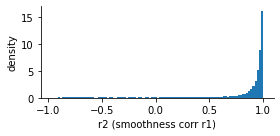

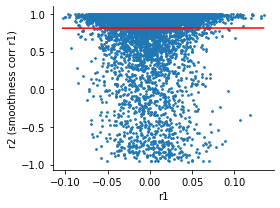

In [2]:
n_point = 100
n_test = 10000
figsize1 = (4, 2)
figsize2 = (4, 3)
out_file1 = pjoin(work_dir, 'smoothness_demo1.jpg')
out_file2 = pjoin(work_dir, 'smoothness_demo2.jpg')
# out_file1 = 'show'
# out_file2 = 'show'

x = np.arange(n_point)
space_ds = pdist(np.expand_dims(x, 1), metric='euclidean')
rs1 = np.zeros(n_test)
win_lens = np.arange(1, 21, 2)
rs2 = np.zeros(n_test)
for i in range(n_test):
    vec = np.random.randn(n_point)

    value_ds1 = pdist(np.expand_dims(vec, 1), metric='euclidean')
    r1 = pearsonr(space_ds, value_ds1)[0]
    rs1[i] = r1

    rs_tmp = [r1]
    for win_len in win_lens[1:]:
        vec_sm = smooth_1d(vec, 'flat', win_len)
        value_ds2 = pdist(np.expand_dims(vec_sm, 1), metric='euclidean')
        r_tmp = pearsonr(space_ds, value_ds2)[0]
        rs_tmp.append(r_tmp)
    rs2[i] = pearsonr(win_lens, rs_tmp)[0]

fig1, ax1 = plt.subplots(1, 1, figsize=figsize1)
ax1.hist(rs2, 100, density=True)
ax1.set_xlabel('r2 (smoothness corr r1)')
ax1.set_ylabel('density')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig1.tight_layout()
if out_file1 == 'show':
    fig1.show()
else:
    fig1.savefig(out_file1)

fig2, ax2 = plt.subplots(1, 1, figsize=figsize2)
plot_polyfit(rs1, rs2, 1, color='r', s=3, ax=ax2)
print("pearsonr(x, y, alternative='two-sided'):\n",
      pearsonr(rs1, rs2, alternative='two-sided'))
ax2.set_xlabel('r1')
ax2.set_ylabel('r2 (smoothness corr r1)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig2.tight_layout()
if out_file2 == 'show':
    fig2.show()
else:
    fig2.savefig(out_file2)

# weight_CCA_beh

## 画出目标潜变量背后的权重分布

### 雷达图

===weight-CCA-beh_MMP-vis3-L_radar===
PC1_beh_vec corr PC2_beh_vec:
 PearsonRResult(statistic=-0.24786796167035824, pvalue=0.3730784265785259)
1: ReadEng_Unadj
2: PicSeq_Unadj
3: SCPT_SEN
4: Mars_Final
5: ProcSpeed_Unadj
6: IWRD_TOT
7: PMAT24_A_CR
8: Odor_Unadj
9: Flanker_Unadj
10: CardSort_Unadj
11: PicVocab_Unadj
12: ListSort_Unadj
13: SCPT_SPEC
14: VSPLOT_TC
15: EVA_Denom
ylim: (-0.5858353054568248, 0.9051580706965167)
yticks: [Decimal('-0.79'), 0, Decimal('0.91')]













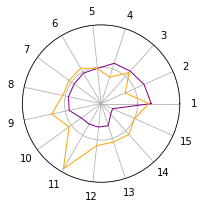

In [3]:
figsize = (3, 3)
vis_name = 'MMP-vis3-L'
pc_names = ('PC1', 'PC2')
pc_name2v = {'PC1': 'v31', 'PC2': 'v32'}
beh_cols = [
    'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj',
    'PMAT24_A_CR', 'ReadEng_Unadj', 'PicVocab_Unadj',
    'ProcSpeed_Unadj', 'VSPLOT_TC', 'SCPT_SEN', 'SCPT_SPEC',
    'IWRD_TOT', 'ListSort_Unadj', 'Odor_Unadj', 'EVA_Denom',
    'Mars_Final']
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_{vis_name}_{v}.pkl')
out_name = f'weight-CCA-beh_{vis_name}_radar'
out_file = pjoin(work_dir, f'{out_name}.svg')
# out_file = 'show'

print(f'==={out_name}===')
n_beh = len(beh_cols)
angles = np.linspace(0, 2 * np.pi, n_beh, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
fig, ax = plt.subplots(1, 1, subplot_kw=dict(polar=True),
                       figsize=figsize)
pc_name2beh_vec = {}
sort_indices = None
for pc_name in pc_names:
    cca_dict = pkl.load(open(fpath.format(
        vis_name=vis_name, v=pc_name2v[pc_name]), 'rb'))
    assert beh_cols == cca_dict['target names']
    beh_weights = cca_dict['model'].y_rotations_[:, 0]
    if sort_indices is None:
        sort_indices = np.argsort(beh_weights)[::-1]
    beh_weights = beh_weights[sort_indices]
    pc_name2beh_vec[pc_name] = beh_weights
    beh_weights = np.r_[beh_weights, beh_weights[0]]
    ax.plot(angles, beh_weights, linewidth=1, linestyle='solid',
            label=pc_name, color=meas2color[pc_name])
print('PC1_beh_vec corr PC2_beh_vec:\n',
      pearsonr(pc_name2beh_vec['PC1'],
               pc_name2beh_vec['PC2'],
               alternative='two-sided'))
# ax.legend(loc='upper left')
# ax.legend()
ax.set_xticks(angles[:-1])
beh_nums = list(range(1, n_beh+1))
ax.set_xticklabels(beh_nums)
beh_cols = [beh_cols[i] for i in sort_indices]
for beh_num, beh_name in zip(beh_nums, beh_cols):
    print(f'{beh_num}:', beh_name)
# ax.set_xticklabels(beh_cols)
ylim = ax.get_ylim()
print('ylim:', ylim)
yticks = [
    round_decimal(ylim[0]-0.2, 2, round_type='floor'),
    0,
    round_decimal(ylim[1], 2, round_type='ceil')]
print('yticks:', yticks)
ax.set_yticks(yticks)
ax.set_yticklabels([])
# ax.grid(axis='y')
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
print('\n'*10)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### 排序显示名字图

===PC1 small behaviors===
PicSeq_Unadj CardSort_Unadj Flanker_Unadj PicVocab_Unadj

===PC1 big behaviors===
CogFluidComp_Unadj CogEarlyComp_Unadj CogCrystalComp_Unadj

===PC2 small behaviors===
CogEarlyComp_Unadj CogTotalComp_Unadj CogCrystalComp_Unadj

===PC2 big behaviors===
ReadEng_Unadj PicVocab_Unadj CogFluidComp_Unadj



<ipython-input-5-4656bf7d7be2>:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


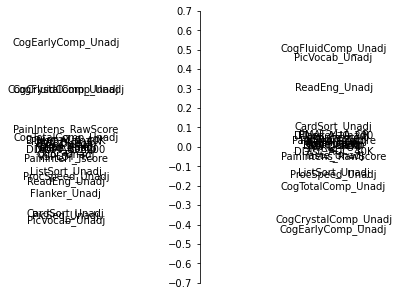

In [5]:
figsize = (3, 5)
vis_name = 'MMP-vis3-R'
pc_names = ('PC1', 'PC2')
pc_name2v = {'PC1': 'v6', 'PC2': 'v7'}
cognition_cols = [
    'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj',
    'PMAT24_A_CR', 'ReadEng_Unadj', 'PicVocab_Unadj',
    'ProcSpeed_Unadj', 'DDisc_AUC_200', 'DDisc_AUC_40K',
    'VSPLOT_TC', 'SCPT_SEN', 'SCPT_SPEC', 'IWRD_TOT',
    'ListSort_Unadj', 'CogFluidComp_Unadj', 'CogEarlyComp_Unadj',
    'CogTotalComp_Unadj', 'CogCrystalComp_Unadj']
sensory_cols = [
    'Noise_Comp', 'Odor_Unadj', 'PainIntens_RawScore',
    'PainInterf_Tscore', 'Taste_Unadj', 'EVA_Denom', 'Mars_Final']
beh_cols = cognition_cols + sensory_cols
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_{vis_name}_{v}.pkl')
out_file = pjoin(work_dir, f'weight-CCA-beh_{vis_name}_sort.svg')
# out_file = 'show'


fig, ax = plt.subplots(1, 1, figsize=figsize)
for pc_name in pc_names:
    if pc_name == 'PC1':
        x = -0.8
        ha, va = 'center', 'center'
    else:
        x = 0.8
        ha, va = 'center', 'center'
    cca_dict = pkl.load(open(fpath.format(
        vis_name=vis_name, v=pc_name2v[pc_name]), 'rb'))
    assert beh_cols == cca_dict['target names']
    beh_weights = cca_dict['model'].y_rotations_[:, 0]
    small_behs = []
    big_behs = []
    for beh_idx, beh_weight in enumerate(beh_weights):
        beh_name = beh_cols[beh_idx]
        ax.text(x, beh_weight, beh_name,
                horizontalalignment=ha, verticalalignment=va)
        if beh_weight < -0.2:
            small_behs.append(beh_name)
        elif beh_weight > 0.2:
            big_behs.append(beh_name)
    print(f'==={pc_name} small behaviors===')
    print(' '.join(small_behs), end='\n\n')
    print(f'==={pc_name} big behaviors===')
    print(' '.join(big_behs), end='\n\n')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(bottom=False, labelbottom=False)
yticks = np.arange(-0.7, 0.7, 0.1)
yticks = np.r_[yticks, (0.7,)]
ax.set_yticks(yticks)
ax.set_ylim(-0.7, 0.7)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 探索梯度与视觉相关行为的关系

In [ ]:
n_subj = 1096
out_file = pjoin(work_dir, 'RSM9.pkl')

brain_meas_names = []
# ---PCA权重---
pc_names = ('C1', 'C2')
# HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj中myelin的权重及其绝对值
weight_m_file = pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv')
weight_m_df = pd.read_csv(weight_m_file, usecols=pc_names)
weight_m_arr = np.c_[weight_m_df, np.abs(weight_m_df)].T
brain_meas_names = [f'{i}_weight_M' for i in pc_names]
brain_meas_names.extend([f'{i}_abs(weight)_M' for i in pc_names])
brain_meas_maps = [weight_m_arr]

# HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj中thickness的权重及其绝对值
weight_t_file = pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv')
weight_t_df = pd.read_csv(weight_t_file, usecols=pc_names)
weight_t_arr = np.c_[weight_t_df, np.abs(weight_t_df)].T
brain_meas_names.extend([f'{i}_weight_T' for i in pc_names])
brain_meas_names.extend([f'{i}_abs(weight)_T' for i in pc_names])
brain_meas_maps.append(weight_t_arr)

# ---HCPY-M+T_fit_PC_subj-wise---
mt_fit_pc_file = pjoin(anal_dir, 'fit/HCPY-M+T_fit_PC_subj-wise.pkl')
mt_fit_pc_data = pkl.load(open(mt_fit_pc_file, 'rb'))
mt_fit_pc_maps = np.zeros((len(mt_fit_pc_data), n_subj))
for k_idx, k in enumerate(mt_fit_pc_data.keys()):
    mt_fit_pc_maps[k_idx] = mt_fit_pc_data[k]
    brain_meas_names.append(k)
brain_meas_maps.append(mt_fit_pc_maps)

# ---behavior measures---
beh_meas_names = ['Color_Vision', 'Eye']
beh_file1 = '/nfs/m1/hcp/S1200_behavior.csv'
beh_file2 = '/nfs/m1/hcp/S1200_behavior_restricted.csv'
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
beh_df1 = pd.read_csv(beh_file1)
beh_df2 = pd.read_csv(beh_file2)
info_df = pd.read_csv(info_file)
assert np.all(beh_df1['Subject'] == beh_df2['Subject'])
beh_df2 = beh_df2.drop('Subject', axis=1)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
# limited in 1096 subjects
subj_ids_beh = beh_df['Subject'].to_list()
subj_indices = [subj_ids_beh.index(i) for i in info_df['subID']]
beh_df = beh_df.loc[subj_indices]

brain_meas_maps = np.concatenate(brain_meas_maps, 0)
for beh_meas_name in beh_meas_names:
    beh_vec = beh_df[beh_meas_name]
    beh_values = tuple(i for i in set(beh_vec) if i is not np.nan)
    val2vec = {}
    for val in beh_values:
        val2vec[val] = beh_vec == val
    n_val = len(beh_values)
    x = np.arange(n_val)
    y = np.zeros(n_val)
    yerr = np.zeros(n_val)
    for brain_meas_idx, brain_meas_name in enumerate(brain_meas_names):
        out_file = pjoin(work_dir, f'{beh_meas_name}_{brain_meas_name}.jpg')
        for idx, val in enumerate(beh_values):
            samples = brain_meas_maps[brain_meas_idx][val2vec[val]]
            y[idx] = np.mean(samples)
            yerr[idx] = sem(samples)
        plot_bar(y, yerr=yerr, x=x, xlabel=beh_meas_name, xticklabel=beh_values,
                 rotate_xticklabel=True, ylabel=brain_meas_name, mode=out_file)

SyntaxError: 'return' outside function (<ipython-input-3-83a69e422a9a>, line 1)

# 画各年龄窗口的年龄范围

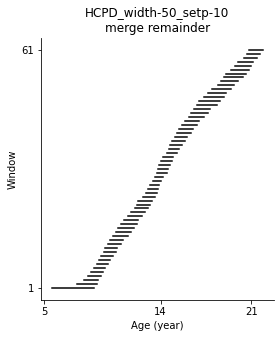

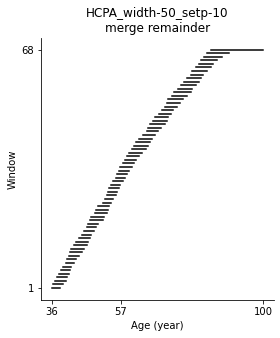

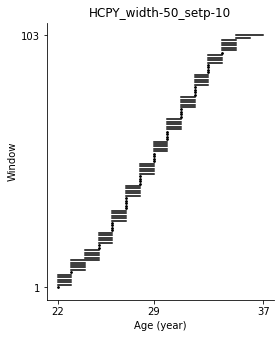

In [5]:
figsize = (4, 4.8)
AgeSlideWindow('HCPD', 50, 10, True).plot_sw_age_range(
    out_file=pjoin(work_dir, 'sw_age_range_HCPD.jpg'), figsize=figsize)

AgeSlideWindow('HCPA', 50, 10, True).plot_sw_age_range(
    out_file=pjoin(work_dir, 'sw_age_range_HCPA.jpg'), figsize=figsize)

AgeSlideWindow('HCPY', 50, 10, True).plot_sw_age_range(
    out_file=pjoin(work_dir, 'sw_age_range_HCPY.jpg'), figsize=figsize)

# 画出HCPD, HCPYA, HCPA重叠年龄平均map的两两之间的散点图，观察能否找到两个数据集之间系统性误差的关系。

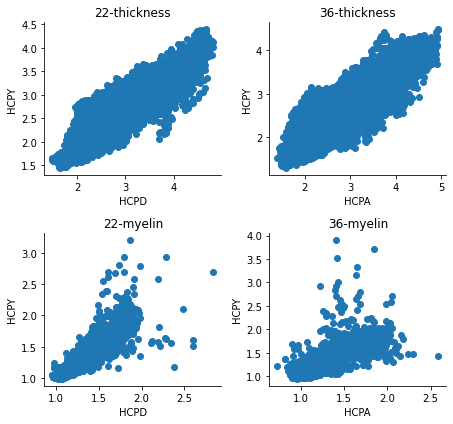

In [ ]:
figsize = (6.4, 6)
meas_names = ('thickness', 'myelin')
meas_files = pjoin(proj_dir, 'analysis/structure/{0}_{1}_age-map-mean.dscalar.nii')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = ['22', '36']
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        trg_age = trg_ages[j]
        meas_file1 = meas_files.format(name_pair[0], meas_name)
        meas_file2 = meas_files.format(name_pair[1], meas_name)
        reader1 = CiftiReader(meas_file1)
        reader2 = CiftiReader(meas_file2)
        idx1 = reader1.map_names().index(trg_age)
        idx2 = reader2.map_names().index(trg_age)
        map1 = reader1.get_data()[idx1]
        map2 = reader2.get_data()[idx2]
        ax.scatter(map1, map2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(f'{name_pair[0]}')
        ax.set_ylabel(f'{name_pair[1]}')
        ax.set_title(f'{trg_age}-{meas_name}')
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'scatter_between_dataset_overlapping-age.jpg'))


# 用置换检验看重叠年龄平均map之间的欧氏距离是否异常，以及zscore能否通过这个考验。

In [ ]:
meas_names = ('thickness', 'myelin')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = [22, 36]

## 置换检验

In [ ]:
N = 10000  # 置换检验的迭代次数
# meas2dataset2file = {
#     'thickness': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness.dscalar.nii'),
#         'HCPY': s1200_1096_thickness,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness.dscalar.nii')
#     },
#     'myelin': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin.dscalar.nii'),
#         'HCPY': s1200_1096_myelin,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin.dscalar.nii')
#     }
# }
meas2dataset2file = {
    'thickness': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_thickness_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness_zscore.dscalar.nii')
    },
    'myelin': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_myelin_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin_zscore.dscalar.nii')
    }
}
out_file = pjoin(work_dir, 'permute_zscore.pkl')

out_data = {}
for meas_name in meas_names:
    out_data[meas_name] = {}
    for j, name_pair in enumerate(dataset_name_pairs):
        time1 = time.time()
        trg_age = trg_ages[j]
        meas_file1 = meas2dataset2file[meas_name][name_pair[0]]
        meas_file2 = meas2dataset2file[meas_name][name_pair[1]]
        info_file1 = dataset_name2info[name_pair[0]]
        info_file2 = dataset_name2info[name_pair[1]]
        df1 = pd.read_csv(info_file1)
        df2 = pd.read_csv(info_file2)
        maps1 = nib.load(meas_file1).get_fdata()[df1['age in years'] == trg_age]
        maps2 = nib.load(meas_file2).get_fdata()[df2['age in years'] == trg_age]

        n_map1 = maps1.shape[0]
        n_map2 = maps2.shape[0]
        idx_vec = np.r_[np.ones(n_map1, bool), np.zeros(n_map2, bool)]
        maps = np.r_[maps1, maps2]
        del maps1, maps2
        diffs = np.zeros(N + 1)
        for k in range(N + 1):
            map1 = np.mean(maps[idx_vec], 0)
            map2 = np.mean(maps[~idx_vec], 0)
            diffs[k] = np.linalg.norm(map1 - map2, ord=2)
            np.random.shuffle(idx_vec)
        out_data[meas_name][name_pair] = diffs
        print(f'Finish {meas_name}-{name_pair}, cost: {time.time() - time1} seconds.')

pkl.dump(out_data, open(out_file, 'wb'))

Finish thickness-('HCPD', 'HCPY'), cost: 467.1382460594177 seconds.
Finish thickness-('HCPA', 'HCPY'), cost: 80.02671980857849 seconds.
Finish myelin-('HCPD', 'HCPY'), cost: 479.2685351371765 seconds.
Finish myelin-('HCPA', 'HCPY'), cost: 66.7187340259552 seconds.


## 画图

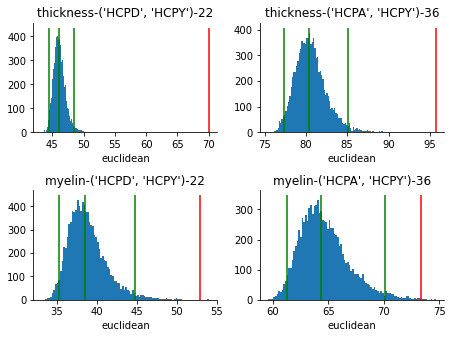

In [ ]:
figsize = (6.4, 4.8)
data_file = pjoin(work_dir, 'permute_zscore.pkl')
data = pkl.load(open(data_file, 'rb'))
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        diffs = data[meas_name][name_pair]
        vline_x1 = diffs[0]
        vline_x2 = np.percentile(diffs[1:], [2.5, 50, 97.5])
        ax.hist(diffs[1:], bins=100)
        ymin, ymax = ax.get_ylim()
        ax.vlines(vline_x1, ymin, ymax, colors='r')
        ax.vlines(vline_x2, ymin, ymax, colors='g')
        ax.set_xlabel('euclidean')
        ax.set_title(f'{meas_name}-{name_pair}-{trg_ages[j]}')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'permute_zscore.jpg'))

# 分背侧，中部和腹侧三条路把ROI按照C1值以及离枕极的距离(gdist)排布开来(C1是横轴，gdist是纵轴。中部路线gdist设置为0，背侧路线gdist归一化到(0, 1)，腹侧路线gdist归一化到(0, 1)后乘以-1)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


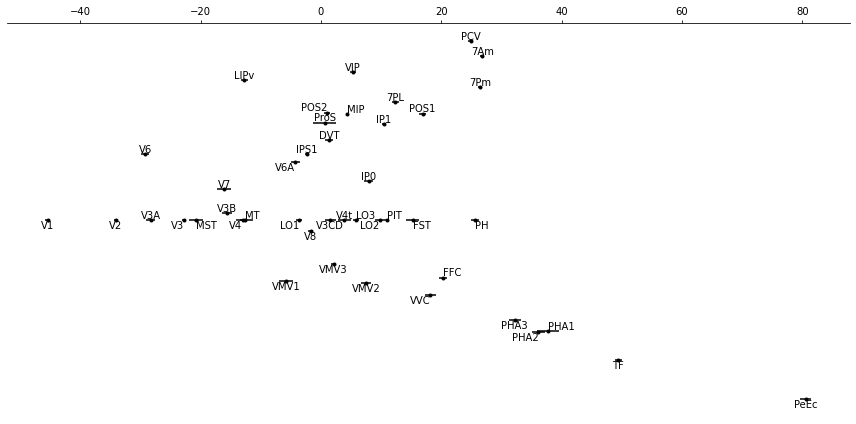

In [ ]:
C1_fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
gdist_fpath = pjoin(anal_dir, 'gdist/gdist_src-OccipitalPole.dscalar.nii')
out_file = pjoin(work_dir, 'dorsal_middle_ventral1.jpg')

atlas = Atlas('HCP-MMP')
rois_dorsal = get_rois('MMP-vis3-G3') + get_rois('MMP-vis3-G16') +\
    get_rois('MMP-vis3-G17') + get_rois('MMP-vis3-G18')
rois_ventral = get_rois('MMP-vis3-G4') + get_rois('MMP-vis3-G13') +\
    get_rois('MMP-vis3-G14')
rois_middle = get_rois('MMP-vis3-G1') + get_rois('MMP-vis3-G2') +\
    get_rois('MMP-vis3-G5')

C1_map = nib.load(C1_fpath).get_fdata()[[0]]
gdist_map = nib.load(gdist_fpath).get_fdata()
n_roi_dorsal = len(rois_dorsal)
n_roi_ventral = len(rois_ventral)
n_roi_middle = len(rois_middle)

# prepare plot for dorsal
x1 = np.zeros(n_roi_dorsal, np.float64)
xerr1 = np.zeros(n_roi_dorsal, np.float64)
y1 = np.zeros(n_roi_dorsal, np.float64)
for roi_idx, roi in enumerate(rois_dorsal):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x1[roi_idx] = np.mean(C1_roi)
    xerr1[roi_idx] = sem(C1_roi)
    y1[roi_idx] = np.mean(gdist_map[mask])
y1 = minmax_scale(y1)

# prepare plot for ventral
x2 = np.zeros(n_roi_ventral, np.float64)
xerr2 = np.zeros(n_roi_ventral, np.float64)
y2 = np.zeros(n_roi_ventral, np.float64)
for roi_idx, roi in enumerate(rois_ventral):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x2[roi_idx] = np.mean(C1_roi)
    xerr2[roi_idx] = sem(C1_roi)
    y2[roi_idx] = np.mean(gdist_map[mask])
y2 = -minmax_scale(y2)

# prepare plot for middle
x3 = np.zeros(n_roi_middle, np.float64)
xerr3 = np.zeros(n_roi_middle, np.float64)
y3 = np.zeros(n_roi_middle, np.float64)
for roi_idx, roi in enumerate(rois_middle):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x3[roi_idx] = np.mean(C1_roi)
    xerr3[roi_idx] = sem(C1_roi)

# prepare plot
x = np.concatenate([x1, x2, x3])
xerr = np.concatenate([xerr1, xerr2, xerr3])
y = np.concatenate([y1, y2, y3])
rois = rois_dorsal + rois_ventral + rois_middle

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x, y, xerr=xerr, ecolor='k', linestyle='', marker='.', mfc='k', mec='k')
for j, i, roi in zip(x, y, rois):
    if roi in ['V3', 'V4', 'LO1', 'PHA2', 'VVC', 'V6A', 'LO2']:
        ha, va = 'right', 'top'
    elif roi in ['MST', 'FST', 'PH']:
        ha, va = 'left', 'top'
    elif roi in ['MT', 'PHA1', 'FFC', 'MIP', 'LO3', 'PIT']:
        ha, va = 'left', 'bottom'
    elif roi in ['POS2']:
        ha, va = 'right', 'bottom'
    elif roi in ['V4t']:
        ha, va = 'center', 'bottom'
    elif roi in rois_dorsal:
        ha, va = 'center', 'bottom'
    else:
        ha, va = 'center', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False, labelleft=False,
               left=False, top=True, labeltop=True)
fig.tight_layout()
fig.savefig(out_file)

# 分背侧，中部和腹侧三条路把ROI按照C1值排布开来(纵轴是C1值，横轴是C1值大小排序的序号。中部路线序号设置为0，背侧路线序号从-1开始往负方向递增，腹侧路线序号从1开始往正方向递增)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


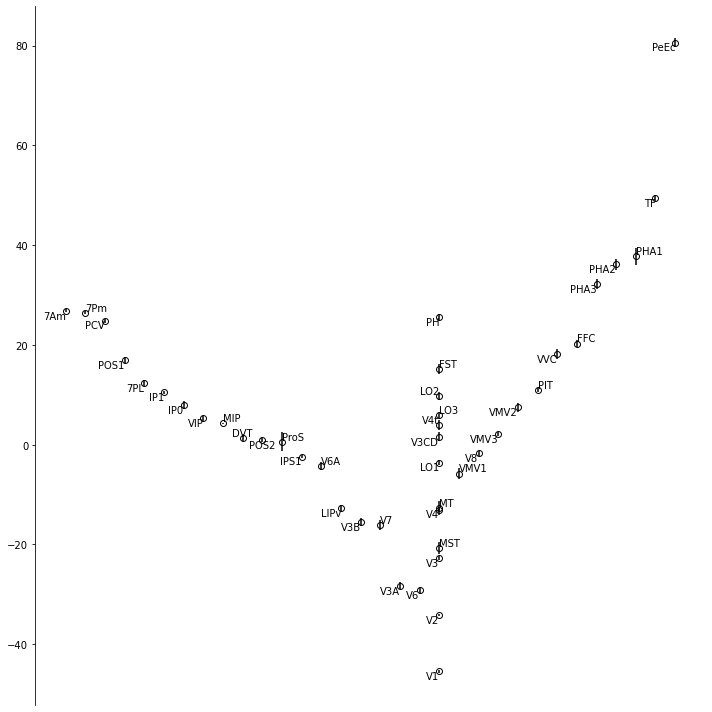

In [ ]:
C1_fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'dorsal_middle_ventral2.jpg')

atlas = Atlas('HCP-MMP')
rois_dorsal = get_rois('MMP-vis3-G3') + get_rois('MMP-vis3-G16') +\
    get_rois('MMP-vis3-G17') + get_rois('MMP-vis3-G18')
rois_ventral = get_rois('MMP-vis3-G4') + get_rois('MMP-vis3-G13') +\
    get_rois('MMP-vis3-G14')
rois_middle = get_rois('MMP-vis3-G1') + get_rois('MMP-vis3-G2') +\
    get_rois('MMP-vis3-G5')

C1_map = nib.load(C1_fpath).get_fdata()[[0]]
n_roi_dorsal = len(rois_dorsal)
n_roi_ventral = len(rois_ventral)
n_roi_middle = len(rois_middle)

# prepare plot for dorsal
y1 = np.zeros(n_roi_dorsal, np.float64)
yerr1 = np.zeros(n_roi_dorsal, np.float64)
x1 = np.arange(-1, -n_roi_dorsal-1, -1)
for roi_idx, roi in enumerate(rois_dorsal):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y1[roi_idx] = np.mean(C1_roi)
    yerr1[roi_idx] = sem(C1_roi)
rois_dorsal = np.array(rois_dorsal)
sort_indices1 = np.argsort(y1)
y1 = y1[sort_indices1]
yerr1 = yerr1[sort_indices1]
rois_dorsal = rois_dorsal[sort_indices1]

# prepare plot for ventral
y2 = np.zeros(n_roi_ventral, np.float64)
yerr2 = np.zeros(n_roi_ventral, np.float64)
x2 = np.arange(1, n_roi_ventral+1)
for roi_idx, roi in enumerate(rois_ventral):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y2[roi_idx] = np.mean(C1_roi)
    yerr2[roi_idx] = sem(C1_roi)
rois_ventral = np.array(rois_ventral)
sort_indices2 = np.argsort(y2)
y2 = y2[sort_indices2]
yerr2 = yerr2[sort_indices2]
rois_ventral = rois_ventral[sort_indices2]

# prepare plot for middle
y3 = np.zeros(n_roi_middle, np.float64)
yerr3 = np.zeros(n_roi_middle, np.float64)
x3 = np.zeros(n_roi_middle)
for roi_idx, roi in enumerate(rois_middle):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y3[roi_idx] = np.mean(C1_roi)
    yerr3[roi_idx] = sem(C1_roi)

# prepare plot
y = np.concatenate([y1, y2, y3])
yerr = np.concatenate([yerr1, yerr2, yerr3])
x = np.concatenate([x1, x2, x3])
rois = np.concatenate([rois_dorsal, rois_ventral, rois_middle])

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(x, y, yerr=yerr, ecolor='k', linestyle='', marker='o', mfc=(1, 1, 1, 0), mec='k')
for j, i, roi in zip(x, y, rois):
    if roi in ['PHA1', 'FFC', 'MIP', 'LO3', 'PIT', 'V7', 'FST', 'MST', 'V6A', 'ProS', 'MT', '7Pm', 'VMV1']:
        ha, va = 'left', 'bottom'
    elif roi in ['LO2', 'V4t']:
        ha, va = 'right', 'bottom'
    elif roi in ['DVT']:
        ha, va = 'center', 'bottom'
    elif roi in ['POS2']:
        ha, va = 'center', 'top'
    else:
        ha, va = 'right', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)
fig.tight_layout()
fig.savefig(out_file)
# fig.show()

# 以stru-PC1为横轴，stru-PC2为纵轴，画出各个ROI的位置

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


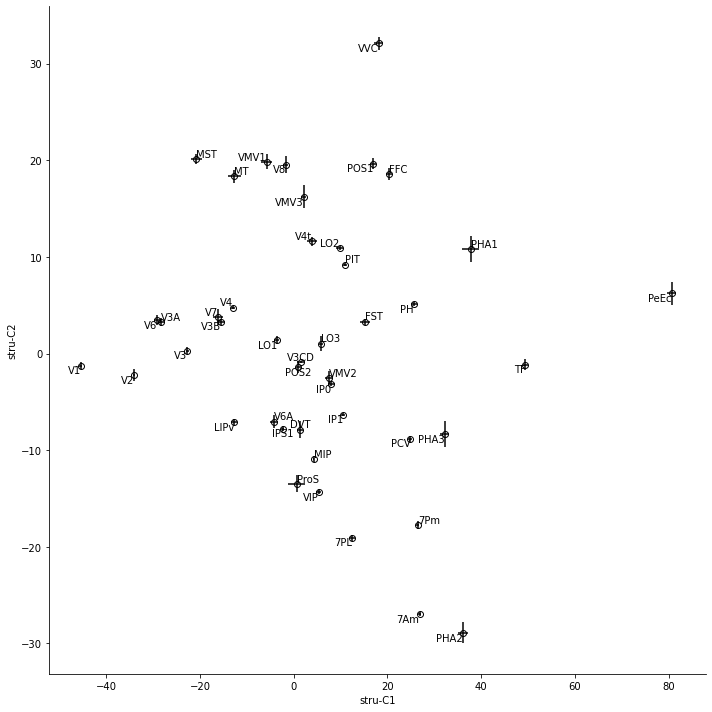

In [ ]:
fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'cartesian-PC1+2_ROI.jpg')

rois = get_rois('MMP-vis3-R')
atlas = Atlas('HCP-MMP')
n_roi = len(rois)
pc_maps = nib.load(fpath).get_fdata()[:2]

# prepare plot
x = np.zeros(n_roi)
xerr = np.zeros(n_roi)
y = np.zeros(n_roi)
yerr = np.zeros(n_roi)
for roi_idx, roi in enumerate(rois):
    mask = atlas.get_mask(roi)[0]
    roi_c1 = pc_maps[0][mask]
    roi_c2 = pc_maps[1][mask]
    x[roi_idx] = np.mean(roi_c1)
    xerr[roi_idx] = sem(roi_c1)
    y[roi_idx] = np.mean(roi_c2)
    yerr[roi_idx] = sem(roi_c2)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(x, y, xerr=xerr, yerr=yerr, ecolor='k', linestyle='',
            marker='o', mfc=(1, 1, 1, 0), mec='k')
for j, i, roi in zip(x, y, rois):
    roi = roi.lstrip('R_')
    if roi in ['PHA1', 'FFC', 'MIP', 'LO3', 'PIT', 'FST', 'MST', 'V6A', 'ProS', 'MT', '7Pm', 'VMV2', 'V3A']:
        ha, va = 'left', 'bottom'
    elif roi in ['LO2', 'V4t', 'V4', 'VMV1', 'V7']:
        ha, va = 'right', 'bottom'
    elif roi in ['DVT', 'V3CD']:
        ha, va = 'center', 'bottom'
    elif roi in ['POS2', 'IPS1']:
        ha, va = 'center', 'top'
    else:
        ha, va = 'right', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.set_xlabel('stru-C1')
ax.set_ylabel('stru-C2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig(out_file)

# 用PC1和PC2分别作为偏心度和极角，用分区颜色给每个点上色

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


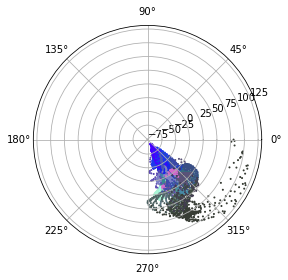

In [ ]:
figsize = None
vis_name = 'MMP-vis3-R'
pca_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')

# target
trg_reader = CiftiReader(mmp_map_file)
out_file = pjoin(work_dir, 'PC1+2_predict_MMP_polar.svg')
# trg_reader = CiftiReader(pjoin(proj_dir, 'data/wang2015/wang2015.32k_fs_LR.dlabel.nii'))
# out_file = pjoin(work_dir, 'PC1+2_predict_wang2015_polar.svg')
# out_file = 'show'
trg_mask = trg_reader.get_data()[0] != 0

mask = np.logical_and(pca_mask, trg_mask)
pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
trg_map = trg_reader.get_data()[0, mask]
lbl_tab = trg_reader.label_tables()[0]
colors = [lbl_tab[i].rgba for i in trg_map]
colors = np.array(colors)

fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
theta = minmax_scale(pc_maps[1], (1.5*np.pi, 2*np.pi))
r = pc_maps[0]
ax.scatter(theta, r, c=colors, s=1)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用PC1和PC2分别作为横轴和纵轴，用分区颜色给每个点上色

## 直接从CIFTI文件读取分区

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


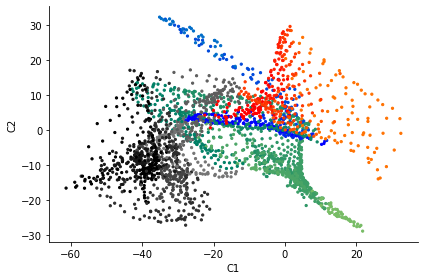

In [2]:
figsize = None
vis_name = 'MMP-vis3-R'
pca_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')

# target
# trg_reader = CiftiReader(mmp_map_file)
# out_file = pjoin(work_dir, 'PC1+2_predict_MMP.jpg')

trg_reader = CiftiReader(pjoin(proj_dir, 'data/wang2015/wang2015.32k_fs_LR.dlabel.nii'))
out_file = pjoin(work_dir, 'PC1+2_predict_wang2015.jpg')

# out_file = 'show'
trg_mask = trg_reader.get_data()[0] != 0

mask = np.logical_and(pca_mask, trg_mask)
pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
trg_map = trg_reader.get_data()[0, mask]
lbl_tab = trg_reader.label_tables()[0]
colors = [lbl_tab[i].rgba for i in trg_map]
colors = np.array(colors)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[0], pc_maps[1], c=colors, s=5)
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 区分脑区边界与非边界

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


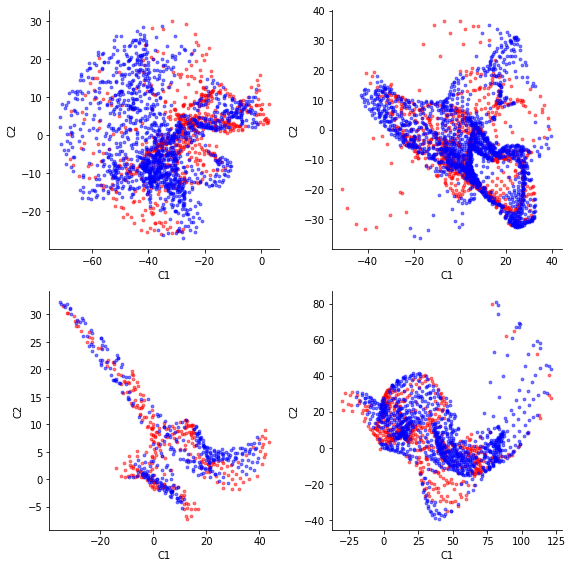

In [2]:
figsize = (8, 8)
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
vis_roi_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_nan-to-0.dlabel.nii')
edlv_names = ('early', 'dorsal', 'lateral', 'ventral')
edlv_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')
out_file = pjoin(work_dir, 'PC1+2_predict_EDLV-MMP-border.jpg')
# out_file = 'show'

# prepare border
Hemi2geo = {
    'L': s1200_midthickness_L,
    'R': s1200_midthickness_R}
Hemi2hemi = {'L': 'lh', 'R': 'rh'}
mw = MedialWall()
gii = GiftiReader(Hemi2geo[Hemi])
faces = mw.remove_from_faces(Hemi2hemi[Hemi], gii.faces)
vis_roi_reader = CiftiReader(vis_roi_file)
vis_roi_map = vis_roi_reader.get_data(Hemi2stru[Hemi], True)[0]
# neighbors = get_n_ring_neighbor(faces, 1, True)
boarder_map = label_edge_detection(vis_roi_map, faces, 'inner')
boarder_map_bin = np.zeros_like(boarder_map)
boarder_map_bin[boarder_map != 0] = 1

pc_maps = CiftiReader(pc_file).get_data(Hemi2stru[Hemi], True)[:2]
edlv_names = [f'{Hemi}_{i}' for i in edlv_names]
edlv_reader = CiftiReader(edlv_file)
edlv_map = edlv_reader.get_data(Hemi2stru[Hemi], True)[0]
edlv_lbl_tab = edlv_reader.label_tables()[0]
edlv_lbl2key = {}
for k, v in edlv_lbl_tab.items():
    edlv_lbl2key[v.label] = k

fig, axes = plt.subplots(2, 2, figsize=figsize)
axes = axes.ravel()
for edlv_i, edlv_n in enumerate(edlv_names):
    ax = axes[edlv_i]
    edlv_mask = edlv_map == edlv_lbl2key[edlv_n]
    boarder_vec = boarder_map_bin[edlv_mask]
    pc1_vec = pc_maps[0, edlv_mask]
    pc2_vec = pc_maps[1, edlv_mask]
    boarder_mask = boarder_vec == 1
    boader_pc1 = pc1_vec[boarder_mask]
    boader_pc2 = pc2_vec[boarder_mask]
    non_boarder_pc1 = pc1_vec[~boarder_mask]
    non_boarder_pc2 = pc2_vec[~boarder_mask]
    ax.scatter(boader_pc1, boader_pc2, c='r', s=8, label='boader', alpha=0.5)
    ax.scatter(non_boarder_pc1, non_boarder_pc2, c='b', s=8, label='boader', alpha=0.5)
    ax.set_xlabel('C1')
    ax.set_ylabel('C2')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用HCPY-M+T_MMP-vis3-{Hemi}_zscore1_PCA-subj的PC1和PC2分别作为x轴和y轴，用HCPYA的平均fALFF来做颜色映射

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


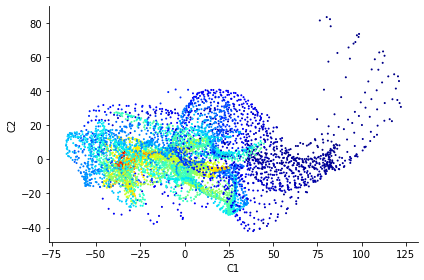

In [ ]:
figsize = (12, 8)
figsize = None
vis_name = 'MMP-vis3-R'
mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')
func_file = pjoin(anal_dir, 'summary_map/HCPY-falff_mean.dscalar.nii')

out_file = pjoin(work_dir, 'PC1+2_fit_fALFF.jpg')
# out_file = 'show'

pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
func_map = nib.load(func_file).get_fdata()[0, mask]


fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[0], pc_maps[1], s=1, c=func_map, cmap='jet')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 统计MMP-vis3-{Hemi}各脑区的顶点数量

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


6849


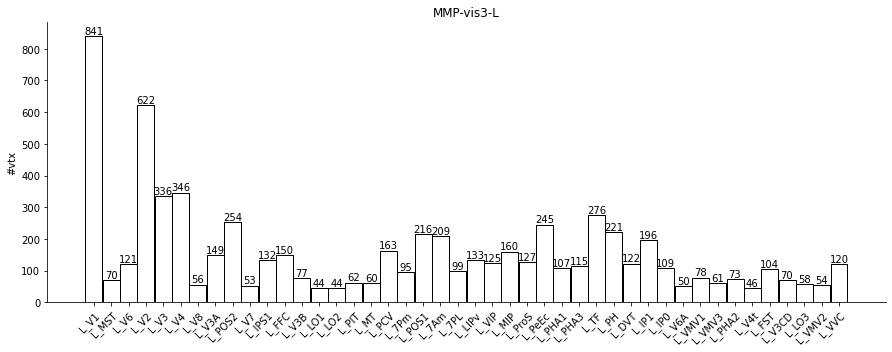

In [2]:
figsize = (12.5, 5)
vis_name = 'MMP-vis3-L'
atlas = Atlas('HCP-MMP')
mode = pjoin(work_dir, f'vtx_num_in_{vis_name}.jpg')
# mode = 'show'

rois = get_rois(vis_name)
y = np.zeros(len(rois), np.uint16)
for roi_idx, roi in enumerate(rois):
    y[roi_idx] = np.sum(atlas.maps[0] == atlas.roi2label[roi])
print(np.sum(y))

plot_bar(y, figsize=figsize, fc_ec_flag=True, fc=('w',), ec=('k',),
         show_height='', xticklabel=tuple(rois), rotate_xticklabel=True,
         ylabel='#vtx', title=vis_name, mode=mode)


# 画PC1和PC2拟合的fALFF map与真实fALFF map的散点图

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


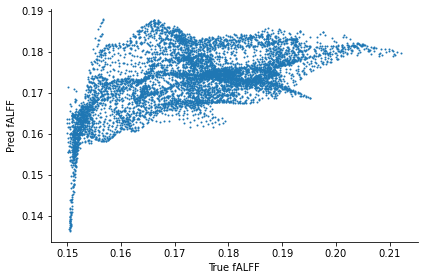

In [ ]:
fpath1 = pjoin(anal_dir, 'summary_map/HCPY-falff_mean.dscalar.nii')
fpath2 = pjoin(anal_dir, 'fit/PC1+2=log(fALFF).dscalar.nii')
mask = Atlas('HCP-MMP').get_mask(get_rois('MMP-vis3-R'))[0]
out_file = pjoin(work_dir, 'fALFF_true-corr_pred.jpg')

map1 = nib.load(fpath1).get_fdata()[0, mask]
map2 = nib.load(fpath2).get_fdata()[0, mask]

fig, ax = plt.subplots()
ax.scatter(map1, map2, 1)
# ax.set_xscale("log")
ax.set_xlabel('True fALFF')
ax.set_ylabel('Pred fALFF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(out_file)

In [ ]:
import math

(0.14, 0.22)

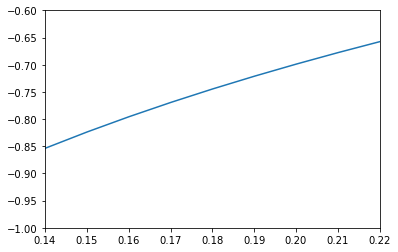

In [ ]:
x = np.linspace(0.0001, 50, 5000)
y = [math.log(i, 10) for i in x]
plt.plot(x, y)
plt.ylim(-1, -0.6)
plt.xlim(0.14, 0.22)